In [87]:
#To use scPN,you need to install scanpy,scvelo,numpy,os,torch,matplotlib.pyplot
#and then ,run the cells below.
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white' 
plt.rcParams['axes.facecolor'] = 'white' 

In [1]:
# dataset Oligolite
#preprocess
import scanpy as sc
import scvelo as scv
raw_data_path='/data1/zzhou/pseudotime/scPN/data/oligo_lite.h5ad'
adata=sc.read(raw_data_path,sparse=True)
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()
#filter genes
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata_100=sc.pp.subsample(adata, fraction=None, n_obs=200, random_state=0, copy=True)
sc.tl.leiden(adata_100, resolution=0.1)
sc.pl.umap(adata_100)
adata_100.write('/data1/zzhou/pseudotime/scPN/data/oligo_lite_100.h5ad')
#add gene matrix
data_path='/data1/zzhou/pseudotime/scPN/data/oligo_lite_100.h5ad'
gene_path='/data1/zzhou/pseudotime/scPN/data/ChEA_2016.txt'
adata_sub=sc.read(data_path)
gene_names = list(adata_sub.var_names)
target_idx=np.zeros((len(gene_names),len(gene_names)))
gene_names= [name.upper() for name in gene_names]
with open(gene_path, "r") as f:
     for line in f.readlines():
         line = line.strip('\n')
         line = line.split('\t')
         TF_info = line[0]
         TF_name = TF_info.split(' ')[0]
         if not TF_name in gene_names:
            continue
         targets= line[2:]
         for target in targets:
             if target in gene_names:
                target_idx[gene_names.index(TF_name),gene_names.index(target)]=1


ModuleNotFoundError: No module named 'scvelo'

In [16]:

import numpy as np
from scipy.spatial.distance import cdist

def find_optimal_sequence(points, max_iter=1000):
    num_points = len(points)
    dist_matrix = cdist(points, points)

    def nearest_neighbor_path(start_idx):
        visited = [False] * num_points
        path = [start_idx]
        visited[start_idx] = True
        for _ in range(1, num_points):
            last = path[-1]
            nearest = np.argmin([dist_matrix[last][j] if not visited[j] else np.inf for j in range(num_points)])
            path.append(nearest)
            visited[nearest] = True
        return path

    def path_length(path):
        return sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))

    def two_opt(path):
        best = path.copy()
        best_dist = path_length(best)

        for _ in range(max_iter):
            improved = False
            for i in range(0, num_points - 2):  # ✅ 包含起点扰动
                for j in range(i + 1, num_points):
                    if j - i == 1:
                        continue
                    new_path = best[:i] + best[i:j][::-1] + best[j:]
                    new_dist = path_length(new_path)
                    if new_dist < best_dist:
                        best = new_path
                        best_dist = new_dist
                        improved = True
                        break
                if improved:
                    break
            if not improved:
                break
        return best

    start = np.random.randint(num_points)
    init_path = nearest_neighbor_path(start)
    optimized_path = two_opt(init_path)
    return optimized_path


In [17]:
import os
import torch
import torch.optim as optim
def optimize_matrix_A(route,adata_file='/data1/zzhou/pseudotime/scPN/data/oligo_lite_100.h5ad',epochs=10000, lr=0.001):
    adata_sub = sc.read(adata_file)

    x = adata_sub.X.toarray()
    n, m = x.shape
    X1=torch.tensor(x,device='cuda',dtype=torch.float32)


    # 初始化需要优化的矩阵A和矩阵W
    A = np.ones((m, m))  # 根据具体需求初始化
#     target_idx = np.random.randn(m, m)  # 这个变量需要定义或从数据中获取
    W = target_idx  # 假设W矩阵和target_idx相关

    # 根据W矩阵定义掩码矩阵
    mask = np.where(W != 0, 1, 0)
    mask_gpu = torch.tensor(mask, device='cuda', dtype=torch.float64)

    # 确保矩阵A中对应W为零的位置也为零
    A *= mask
    A_gpu = torch.tensor(A, requires_grad=True, device='cuda', dtype=torch.float64)

    # 初始化优化器
    optimizer = optim.Adam([A_gpu], lr=lr)

    # 定义目标函数
    def objective_function_A(A, route):
        scalar = torch.tensor(1, device='cuda', dtype=torch.float64)
        target_idx_gpu = torch.tensor(target_idx, device='cuda', dtype=torch.float64)
        dy_gpu = torch.tensor(dy(route, x), device='cuda', dtype=torch.float64)
        Ones = torch.ones(m, m, device='cuda', dtype=torch.float64)
        W_gpu = torch.tensor(W, device='cuda', dtype=torch.float64)
        X1=torch.tensor(x,device='cuda')

#         distance_matrix=distance_matrix2.cpu().detach().numpy()
#         total_distance = 0.0
#         for i in range(len(route) - 1):
#             total_distance += distance_matrix[route[i]-1, route[i + 1]-1]
        W_reciprocal = torch.reciprocal(100 * target_idx_gpu + scalar * Ones)

        x_t = np.zeros((n, m))
        for i in range(n):
            x_t[i] = x[route[i] - 1, :]
        x_t_gpu = torch.tensor(x_t[2:n-3, :], device='cuda', dtype=torch.float64)
#         distance_matrix2=torch.cdist(X1A,X1A,p=2)
        X1A_gpu = torch.mm(x_t_gpu, A)
        W_hadamard_A_gpu = torch.mul(W_reciprocal, A)
        matrix = dy_gpu - X1A_gpu
        matrix_norm = torch.norm(matrix, p='fro')
        W_hadamard_A_norm = torch.norm(W_hadamard_A_gpu, p='fro')
        x_t_minus=torch.diff(x_t_gpu, dim=0)
        total_distance=torch.norm(torch.mm(x_t_minus,A),p='fro')
        loss = matrix_norm+W_hadamard_A_norm+total_distance
        return loss

    def dy(route, x):
        m, n = x.shape
        dy1 = np.zeros((m-5, n))
        deltat = 1 / (m-1)
        for t in range(2, m - 3):
            dy1[t - 2, :] = (8 * x[route[t + 1]-1, :] - 8 * x[route[t - 1]-1, :] + x[route[t - 2]-1, :] - x[route[t + 2]-1, :]) / (12 * deltat)
        return dy1

    # 进行优化迭代
    for i in range(epochs):
        optimizer.zero_grad()  # 每次迭代前将梯度清零
        loss = objective_function_A(A_gpu, route)
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新矩阵A的数值
        
        # 应用掩码，使非优化元素保持为零
        with torch.no_grad():
            A_gpu *= mask_gpu
        
        # if i % 1000 == 0:  # 每1000次迭代打印一次损失
        #     print(f"Iteration {i}, loss: {loss.item()}")

#     print("Optimized matrix A:")
    return A_gpu.cpu().detach().numpy()

def getdistance(A,adata_sub):
    u, s, v = np.linalg.svd(A)
    n,m=adata_sub.shape
    X1=torch.tensor(adata_sub,device='cuda',dtype=torch.float32)

    A=torch.tensor(A,device='cuda',dtype=torch.float32)
    X1A=torch.mm(X1, A)
# print(XA.shape,XB.shape,type(XA),type(XB))
    distance_matrix1=torch.cdist(X1, X1, p=2)
    distance_matrix2=torch.dist(X1A,X1A,p=2)
    # print(distance_matrix1,distance_matrix2)
    distance_matrix=distance_matrix1+distance_matrix2/(s[0]+1)
    distance=np.array(distance_matrix.cpu())
    return distance
# from python_tsp.exact import solve_tsp_dynamic_programming
# from python_tsp.heuristics import solve_tsp_simulated_annealing
# from python_tsp.heuristics import solve_tsp_local_search
if not os.path.exists('n_filename'):
    x=adata_sub.X.toarray()
    A = np.zeros((x.shape[1], x.shape[1]))
    best_route = None
    for iteration in range(10):
        distance_matrix = getdistance(A, x)
        route=find_optimal_sequence(x)
        # route, _ = solve_tsp_simulated_annealing(distance_matrix)
        # route, _ = solve_tsp_local_search(distance_matrix)
        print(route)
        A = optimize_matrix_A(route)

[183, 62, 155, 175, 23, 37, 86, 137, 168, 93, 71, 35, 117, 110, 109, 84, 112, 63, 160, 171, 163, 177, 82, 67, 130, 100, 138, 11, 166, 148, 144, 49, 189, 30, 106, 98, 2, 65, 50, 32, 54, 188, 159, 198, 153, 199, 74, 95, 17, 88, 91, 48, 43, 69, 27, 41, 60, 85, 46, 186, 173, 118, 167, 161, 129, 94, 114, 39, 196, 64, 103, 55, 135, 179, 141, 139, 56, 83, 8, 28, 165, 145, 190, 115, 119, 19, 40, 87, 57, 192, 191, 61, 34, 52, 59, 58, 77, 133, 116, 18, 26, 80, 14, 51, 9, 176, 31, 154, 102, 134, 33, 1, 164, 38, 149, 47, 45, 4, 75, 193, 99, 157, 194, 125, 124, 96, 24, 20, 0, 42, 3, 147, 180, 25, 127, 142, 170, 197, 72, 111, 140, 156, 90, 174, 6, 10, 169, 181, 107, 21, 15, 143, 7, 132, 195, 44, 128, 126, 89, 53, 123, 70, 76, 36, 97, 151, 22, 29, 78, 162, 104, 68, 152, 81, 136, 16, 131, 184, 150, 158, 172, 122, 185, 73, 79, 182, 113, 120, 101, 108, 105, 146, 178, 187, 121, 13, 5, 12, 92, 66]
[183, 62, 155, 175, 23, 37, 86, 137, 168, 189, 49, 144, 148, 166, 11, 138, 93, 71, 35, 117, 110, 109, 84, 112

In [35]:
import numpy as np
import scvelo as scv
import scanpy as sc
import pandas as pd
neighbors=75

# filename='/data1/zzhou/pseudotime/scPN/data/oligo_answer.csv'
# Answer=pd.read_csv(filename).values
n=len(Answer)
n=len(Answer)
q=0
U=np.zeros(n)
for i in range(n):
    
    U[Answer[-i]-1]=1/n*q
    q+=1
adata_sub.obs['latent_time']=U
scv.pp.neighbors(adata_sub, n_neighbors=neighbors)
neighbor_matrix=adata_sub.uns['neighbors']['indices']
neighbor_matrix=adata_sub.uns['neighbors']['indices']
k=neighbors
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata_sub.obs['pseudotime']=U_KNN/U_KNN.max()

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [36]:
import numpy as np
from scipy.spatial.distance import cdist
def interpolate_pseudotime_full(adata, adata_subset, k=5):
    # 1. 全部点的表达数据
    X_all = adata.X.toarray()
    X_sub = adata_subset.X.toarray()
    print(X_all.shape,X_sub.shape)
    # 2. 找出子集在原始 adata 中的 index
    anchor_indices = [adata.obs_names.get_loc(name) for name in adata_subset.obs_names]
    
    # 3. 获取 anchor 的 pseudotime
    pseudotime_anchor = adata_subset.obs["pseudotime"].values
    N = X_all.shape[0]
    
    # 4. 计算距离
    dists = cdist(X_all, X_sub)
    
    # 5. 插值 pseudotime
    pseudotime_full = np.full(N, np.nan)
    pseudotime_full[anchor_indices] = pseudotime_anchor
    
    for i in range(N):
        if not np.isnan(pseudotime_full[i]):
            continue
        nearest_idx = np.argsort(dists[i])[:k]
        nearest_dists = dists[i][nearest_idx]
        nearest_times = pseudotime_anchor[nearest_idx]

        weights = 1 / (nearest_dists + 1e-6)
        weights /= weights.sum()
        pseudotime_full[i] = np.dot(weights, nearest_times)
    
    # 6. 写入 adata.obs
    adata.obs["pseudotime"] = pseudotime_full
interpolate_pseudotime_full(adata, adata_sub, k=50)


(6253, 1000) (200, 1000)


In [44]:
U_KNN.values

array([1.61860969, 0.86881527, 0.94653887, ..., 0.94501476, 0.94688027,
       0.84984194])

Running scvelo 0.2.5 (python 3.9.12) on 2025-04-29 05:16.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

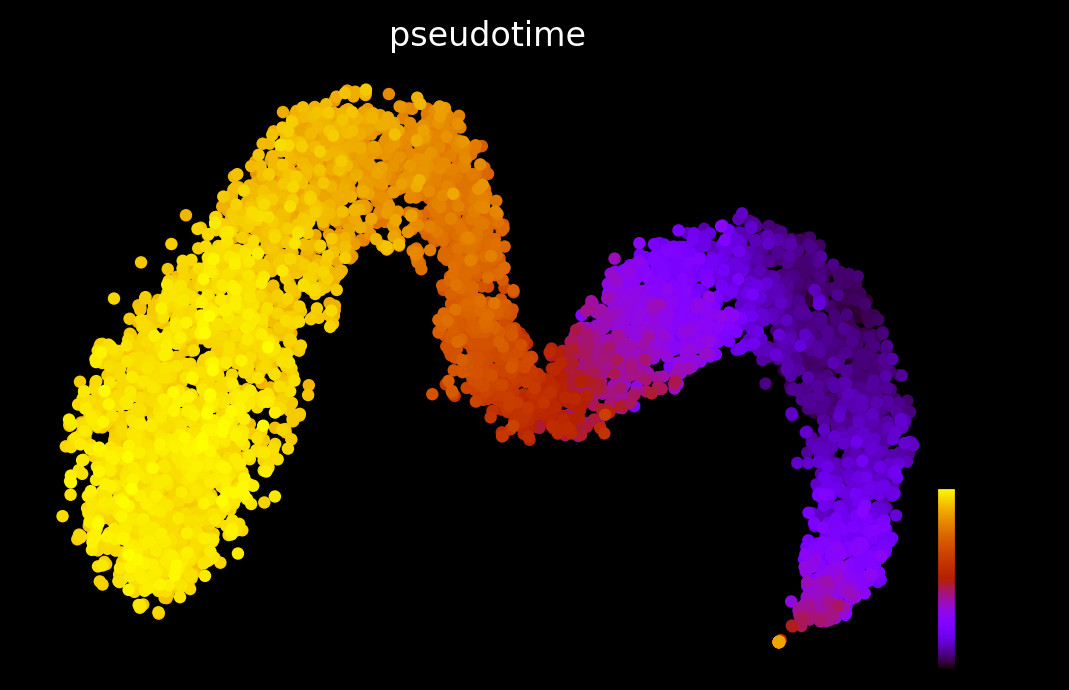

In [50]:
import scanpy as sc
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()
scv.pp.neighbors(adata, n_neighbors=100)
neighbor_matrix=adata.uns['neighbors']['indices']
neighbor_matrix=adata.uns['neighbors']['indices']
k=100
n=adata.X.toarray().shape[0]
U=adata.obs['pseudotime'].values
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata.obs['pseudotime']=U_KNN/U_KNN.max()
scv.pl.scatter(adata, color='pseudotime', color_map='gnuplot', size=80,basis='X_umap')

Running scvelo 0.2.5 (python 3.9.12) on 2025-04-29 05:31.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorfl

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:22) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


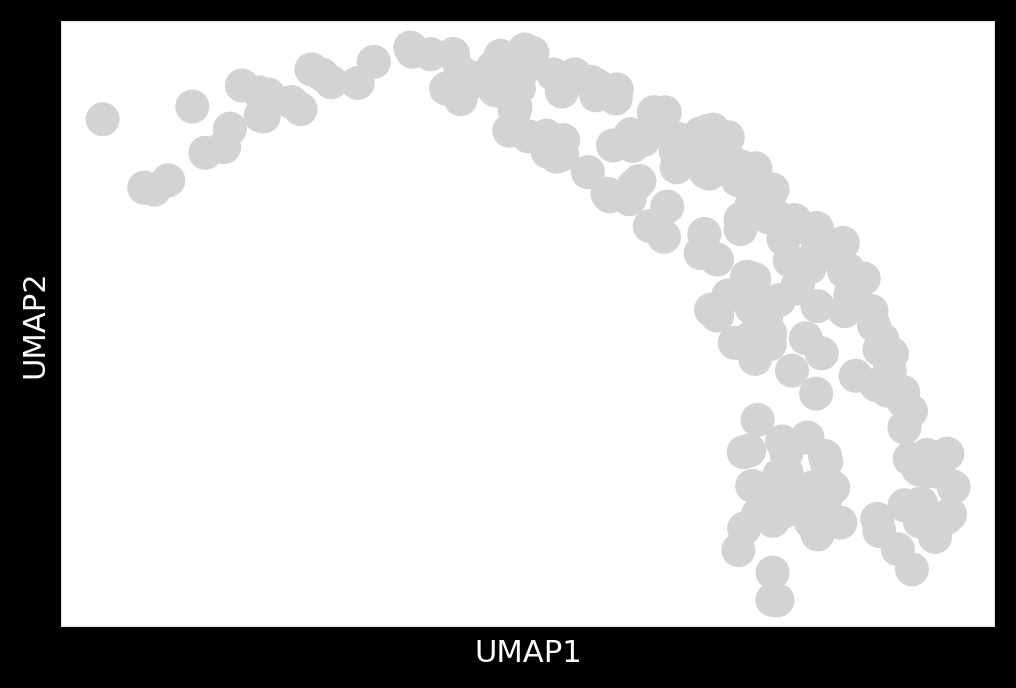

In [52]:
# dataset Gastrulation
#preprocess
import scanpy as sc
import scvelo as scv
raw_data_path='/data1/zzhou/pseudotime/scPN/data/erythroid_lineage.h5ad'
adata=sc.read(raw_data_path,sparse=True)
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()
#filter genes
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata_100=sc.pp.subsample(adata, fraction=None, n_obs=200, random_state=0, copy=True)
sc.tl.leiden(adata_100, resolution=0.1)
sc.pl.umap(adata_100)
adata_100.write('/data1/zzhou/pseudotime/scPN/data/erythroid_lineage_100.h5ad')
#add gene matrix
data_path='/data1/zzhou/pseudotime/scPN/data/erythroid_lineage_100.h5ad'
gene_path='/data1/zzhou/pseudotime/scPN/data/ChEA_2016.txt'
adata_sub=sc.read(data_path)
gene_names = list(adata_sub.var_names)
target_idx=np.zeros((len(gene_names),len(gene_names)))
gene_names= [name.upper() for name in gene_names]
with open(gene_path, "r") as f:
     for line in f.readlines():
         line = line.strip('\n')
         line = line.split('\t')
         TF_info = line[0]
         TF_name = TF_info.split(' ')[0]
         if not TF_name in gene_names:
            continue
         targets= line[2:]
         for target in targets:
             if target in gene_names:
                target_idx[gene_names.index(TF_name),gene_names.index(target)]=1


In [53]:
#TSP
import numpy as np
from scipy.spatial.distance import cdist

def find_optimal_sequence(points, max_iter=1000):
    num_points = len(points)
    dist_matrix = cdist(points, points)

    def nearest_neighbor_path(start_idx):
        visited = [False] * num_points
        path = [start_idx]
        visited[start_idx] = True
        for _ in range(1, num_points):
            last = path[-1]
            nearest = np.argmin([dist_matrix[last][j] if not visited[j] else np.inf for j in range(num_points)])
            path.append(nearest)
            visited[nearest] = True
        return path

    def path_length(path):
        return sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))

    def two_opt(path):
        best = path.copy()
        best_dist = path_length(best)

        for _ in range(max_iter):
            improved = False
            for i in range(0, num_points - 2):  # ✅ 包含起点扰动
                for j in range(i + 1, num_points):
                    if j - i == 1:
                        continue
                    new_path = best[:i] + best[i:j][::-1] + best[j:]
                    new_dist = path_length(new_path)
                    if new_dist < best_dist:
                        best = new_path
                        best_dist = new_dist
                        improved = True
                        break
                if improved:
                    break
            if not improved:
                break
        return best

    start = np.random.randint(num_points)
    init_path = nearest_neighbor_path(start)
    optimized_path = two_opt(init_path)
    return optimized_path


In [56]:
import os
import torch
import torch.optim as optim
def optimize_matrix_A(route,adata_file='/data1/zzhou/pseudotime/scPN/data/erythoid_lineage_100.h5ad',epochs=10000, lr=0.001):
    # adata_sub = sc.read(adata_file)

    x = adata_sub.X.toarray()
    n, m = x.shape
    X1=torch.tensor(x,device='cuda',dtype=torch.float32)


    # 初始化需要优化的矩阵A和矩阵W
    A = np.ones((m, m))  # 根据具体需求初始化
#     target_idx = np.random.randn(m, m)  # 这个变量需要定义或从数据中获取
    W = target_idx  # 假设W矩阵和target_idx相关

    # 根据W矩阵定义掩码矩阵
    mask = np.where(W != 0, 1, 0)
    mask_gpu = torch.tensor(mask, device='cuda', dtype=torch.float64)

    # 确保矩阵A中对应W为零的位置也为零
    A *= mask
    A_gpu = torch.tensor(A, requires_grad=True, device='cuda', dtype=torch.float64)

    # 初始化优化器
    optimizer = optim.Adam([A_gpu], lr=lr)

    # 定义目标函数
    def objective_function_A(A, route):
        scalar = torch.tensor(1, device='cuda', dtype=torch.float64)
        target_idx_gpu = torch.tensor(target_idx, device='cuda', dtype=torch.float64)
        dy_gpu = torch.tensor(dy(route, x), device='cuda', dtype=torch.float64)
        Ones = torch.ones(m, m, device='cuda', dtype=torch.float64)
        W_gpu = torch.tensor(W, device='cuda', dtype=torch.float64)
        X1=torch.tensor(x,device='cuda')

#         distance_matrix=distance_matrix2.cpu().detach().numpy()
#         total_distance = 0.0
#         for i in range(len(route) - 1):
#             total_distance += distance_matrix[route[i]-1, route[i + 1]-1]
        W_reciprocal = torch.reciprocal(100 * target_idx_gpu + scalar * Ones)

        x_t = np.zeros((n, m))
        for i in range(n):
            x_t[i] = x[route[i] - 1, :]
        x_t_gpu = torch.tensor(x_t[2:n-3, :], device='cuda', dtype=torch.float64)
#         distance_matrix2=torch.cdist(X1A,X1A,p=2)
        X1A_gpu = torch.mm(x_t_gpu, A)
        W_hadamard_A_gpu = torch.mul(W_reciprocal, A)
        matrix = dy_gpu - X1A_gpu
        matrix_norm = torch.norm(matrix, p='fro')
        W_hadamard_A_norm = torch.norm(W_hadamard_A_gpu, p='fro')
        x_t_minus=torch.diff(x_t_gpu, dim=0)
        total_distance=torch.norm(torch.mm(x_t_minus,A),p='fro')
        loss = matrix_norm+W_hadamard_A_norm+total_distance
        return loss

    def dy(route, x):
        m, n = x.shape
        dy1 = np.zeros((m-5, n))
        deltat = 1 / (m-1)
        for t in range(2, m - 3):
            dy1[t - 2, :] = (8 * x[route[t + 1]-1, :] - 8 * x[route[t - 1]-1, :] + x[route[t - 2]-1, :] - x[route[t + 2]-1, :]) / (12 * deltat)
        return dy1

    # 进行优化迭代
    for i in range(epochs):
        optimizer.zero_grad()  # 每次迭代前将梯度清零
        loss = objective_function_A(A_gpu, route)
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新矩阵A的数值
        
        # 应用掩码，使非优化元素保持为零
        with torch.no_grad():
            A_gpu *= mask_gpu
        
        # if i % 1000 == 0:  # 每1000次迭代打印一次损失
        #     print(f"Iteration {i}, loss: {loss.item()}")

#     print("Optimized matrix A:")
    return A_gpu.cpu().detach().numpy()

def getdistance(A,adata_sub):
    u, s, v = np.linalg.svd(A)
    n,m=adata_sub.shape
    X1=torch.tensor(adata_sub,device='cuda',dtype=torch.float32)

    A=torch.tensor(A,device='cuda',dtype=torch.float32)
    X1A=torch.mm(X1, A)
# print(XA.shape,XB.shape,type(XA),type(XB))
    distance_matrix1=torch.cdist(X1, X1, p=2)
    distance_matrix2=torch.dist(X1A,X1A,p=2)
    # print(distance_matrix1,distance_matrix2)
    distance_matrix=distance_matrix1+distance_matrix2/(s[0]+1)
    distance=np.array(distance_matrix.cpu())
    return distance
# from python_tsp.exact import solve_tsp_dynamic_programming
# from python_tsp.heuristics import solve_tsp_simulated_annealing
# from python_tsp.heuristics import solve_tsp_local_search
if not os.path.exists('n_filename'):
    x=adata_sub.X.toarray()
    A = np.zeros((x.shape[1], x.shape[1]))
    best_route = None
    for iteration in range(10):
        distance_matrix = getdistance(A, x)
        route=find_optimal_sequence(x)
        # route, _ = solve_tsp_simulated_annealing(distance_matrix)
        # route, _ = solve_tsp_local_search(distance_matrix)
        print(route)
        A = optimize_matrix_A(route)

[151, 126, 32, 0, 24, 58, 94, 49, 4, 178, 142, 85, 153, 106, 91, 42, 31, 3, 157, 40, 155, 173, 161, 36, 73, 12, 29, 166, 127, 10, 22, 137, 120, 122, 114, 158, 189, 15, 131, 53, 61, 197, 11, 99, 83, 124, 198, 148, 169, 28, 81, 89, 195, 26, 105, 44, 86, 150, 190, 60, 77, 97, 56, 66, 191, 152, 133, 30, 101, 129, 43, 144, 108, 34, 80, 76, 21, 123, 57, 143, 156, 140, 141, 8, 7, 74, 51, 180, 167, 130, 14, 64, 115, 70, 102, 5, 182, 63, 187, 52, 132, 159, 71, 27, 185, 48, 104, 68, 13, 135, 9, 199, 192, 163, 149, 117, 183, 175, 45, 38, 35, 134, 107, 54, 78, 138, 103, 172, 168, 119, 16, 98, 160, 118, 145, 46, 93, 146, 194, 59, 109, 20, 88, 111, 41, 181, 84, 75, 17, 47, 79, 162, 184, 50, 65, 92, 19, 6, 147, 154, 121, 25, 110, 179, 39, 2, 72, 33, 62, 139, 196, 170, 23, 128, 112, 177, 69, 176, 165, 96, 1, 95, 18, 188, 171, 87, 113, 164, 125, 136, 90, 55, 67, 37, 186, 100, 174, 116, 193, 82]
[151, 126, 32, 136, 137, 0, 24, 58, 67, 55, 90, 85, 153, 190, 113, 99, 83, 125, 87, 164, 66, 191, 105, 120, 1

In [57]:
Answer=[151, 126, 32, 61, 53, 157, 31, 3, 40, 160, 118, 168, 47, 196, 144, 38, 35, 134, 107, 54, 170, 23, 79, 128, 112, 177, 84, 78, 138, 62, 139, 72, 33, 6, 19, 154, 147, 74, 51, 180, 7, 8, 175, 183, 108, 34, 80, 182, 63, 187, 52, 64, 14, 143, 156, 140, 57, 141, 76, 21, 123, 102, 71, 27, 185, 48, 104, 163, 149, 117, 167, 130, 115, 68, 13, 135, 9, 199, 192, 159, 132, 5, 70, 172, 103, 16, 119, 98, 39, 2, 179, 110, 162, 184, 50, 92, 65, 17, 75, 25, 121, 45, 46, 145, 146, 194, 43, 93, 129, 88, 111, 41, 181, 59, 109, 20, 191, 66, 152, 133, 30, 101, 150, 190, 42, 26, 195, 165, 96, 1, 89, 81, 91, 106, 153, 11, 161, 173, 155, 86, 44, 105, 10, 127, 95, 18, 188, 142, 0, 67, 136, 125, 83, 99, 197, 73, 36, 15, 189, 158, 198, 148, 169, 56, 97, 77, 60, 124, 28, 176, 69, 12, 29, 166, 171, 87, 164, 113, 131, 22, 114, 122, 120, 137, 24, 58, 94, 49, 4, 178, 55, 90, 85, 37, 186, 116, 100, 174, 193, 82]

In [84]:
import numpy as np
import scvelo as scv
import scanpy as sc
import pandas as pd
neighbors=75

# filename='/data1/zzhou/pseudotime/scPN/data/oligo_answer.csv'
# Answer=pd.read_csv(filename).values
n=len(Answer)
n=len(Answer)
q=0
U=np.zeros(n)
for i in range(n):
    
    U[Answer[i]-1]=1/n*q
    q+=1
adata_sub.obs['latent_time']=U
scv.pp.neighbors(adata_sub, n_neighbors=neighbors)
neighbor_matrix=adata_sub.uns['neighbors']['indices']
neighbor_matrix=adata_sub.uns['neighbors']['indices']
k=neighbors
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata_sub.obs['pseudotime']=U_KNN/U_KNN.max()

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [85]:
interpolate_pseudotime_full(adata, adata_sub, k=50)

(9815, 1000) (200, 1000)


In [72]:
neighbor_matrix.shape

(200, 75)

Running scvelo 0.2.5 (python 3.9.12) on 2025-04-29 17:13.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

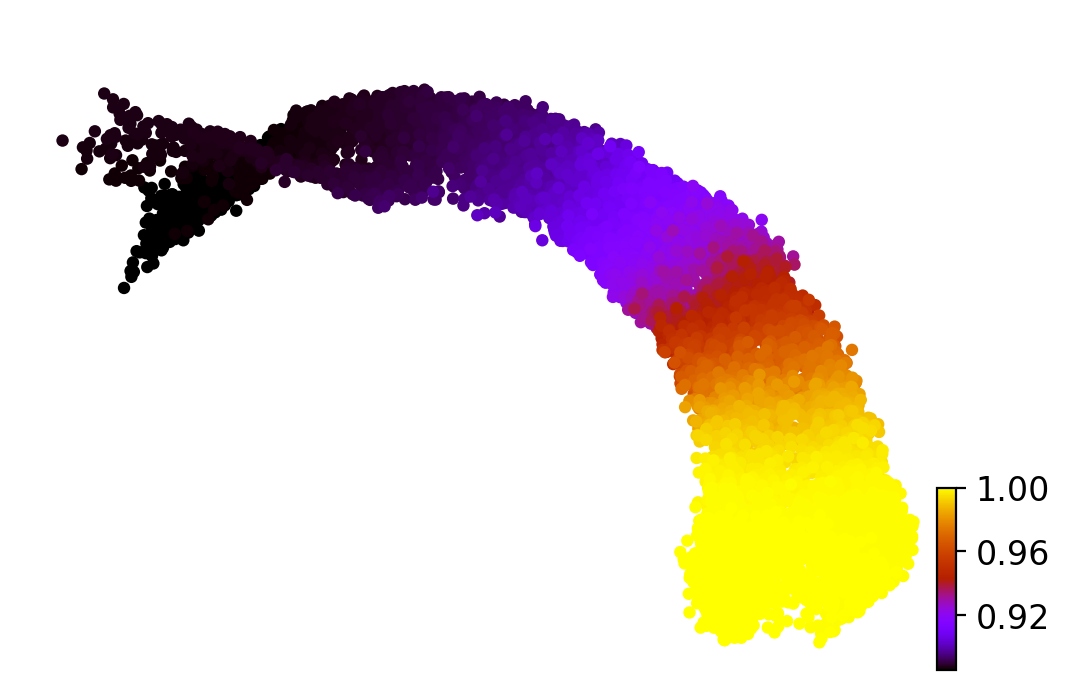

In [88]:
import scanpy as sc
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()
scv.pp.neighbors(adata, n_neighbors=100)
neighbor_matrix=adata.uns['neighbors']['indices']
neighbor_matrix=adata.uns['neighbors']['indices']
k=100
n=adata.X.toarray().shape[0]
U=adata.obs['pseudotime'].values
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
    
adata.obs['pseudotime']=U_KNN/U_KNN.max()
scv.pl.scatter(adata, color='pseudotime', color_map='gnuplot', size=80,basis='X_umap')

In [99]:
#DentateGyrus
import scanpy as sc
import scvelo as scv
raw_data_path='/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad'
adata=sc.read(raw_data_path,sparse=True)
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()

# adata_=adata[adata.obs['ClusterName'].isin(['CA','CA1_Sub','CA2-3-4','Granule','Nbl1','Nbl2','nIPC','RadialGlia','GlialProg','OPC','ImmAstro'])]
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Running scvelo 0.2.5 (python 3.9.12) on 2025-04-29 17:24.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorfl

Filtered out 727 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(values):


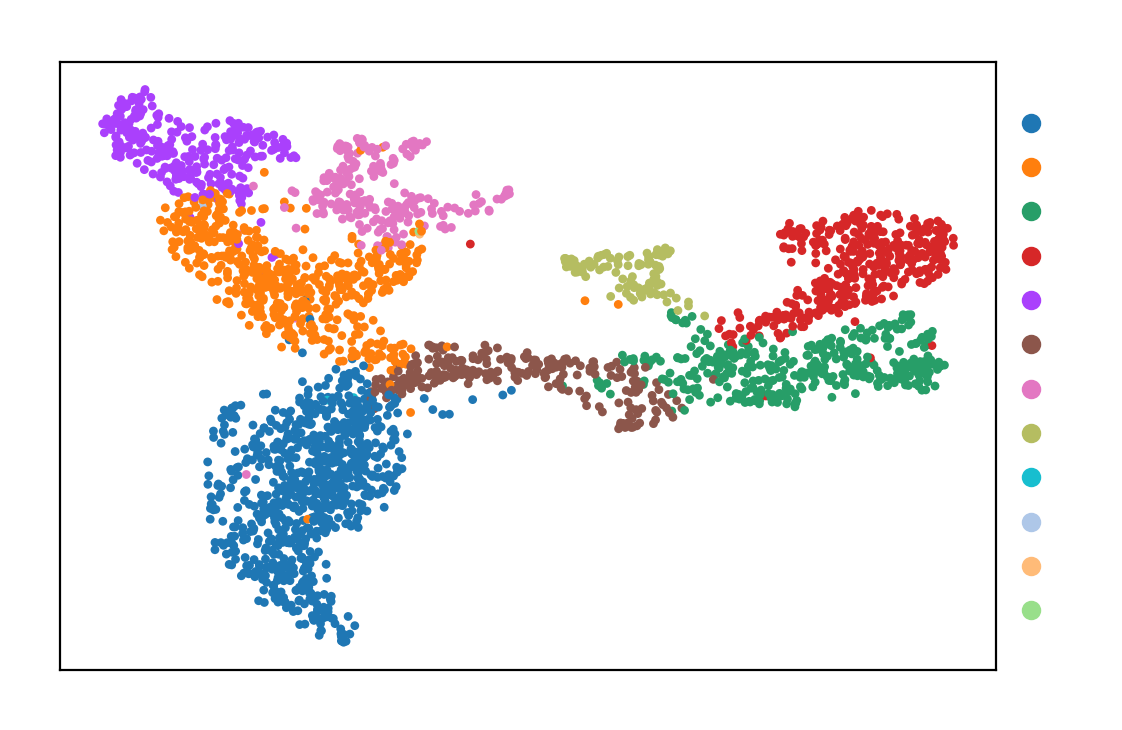

In [100]:
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata,color='leiden')

In [95]:
import scanpy as sc
import numpy as np
data_path='/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad'
gene_path='/data1/zzhou/pseudotime/scPN/data/ChEA_2016.txt'
adata=sc.read(data_path)
gene_names = list(adata.var_names)
target_idx=np.zeros((len(gene_names),len(gene_names)))
gene_names= [name.upper() for name in gene_names]
with open(gene_path, "r") as f:
     for line in f.readlines():
         line = line.strip('\n')
         line = line.split('\t')
         TF_info = line[0]
         TF_name = TF_info.split(' ')[0]
         if not TF_name in gene_names:
            continue
         targets= line[2:]
         for target in targets:
             if target in gene_names:
                target_idx[gene_names.index(TF_name),gene_names.index(target)]=1

In [ ]:
import torch
import torch.optim as optim
target_idx = torch.tensor(target_idx, device='cuda',dtype=torch.float32)
x=adata_3000.X.toarray()
def optimize_matrix_A(route,cluster='0', adata_file='adata3000_imputed_leiden11_ID.h5ad',epochs=10000, lr=0.001):
    # 加载数据并处理
    adata = sc.read(adata_file)
    adata_0 = adata[adata.obs['leiden'] == cluster].X
    x = adata_0.toarray()
    n, m = x.shape
    X1=torch.tensor(x,device='cuda',dtype=torch.float32)


    # 初始化需要优化的矩阵A和矩阵W
    A = np.ones((m, m))  # 根据具体需求初始化
#     target_idx = np.random.randn(m, m)  # 这个变量需要定义或从数据中获取
    W = target_idx.cpu().detach().numpy()  # 假设W矩阵和target_idx相关

    # 根据W矩阵定义掩码矩阵
    mask = np.where(W != 0, 1, 0)
    mask_gpu = torch.tensor(mask, device='cuda', dtype=torch.float64)

    # 确保矩阵A中对应W为零的位置也为零
    A *= mask
    A_gpu = torch.tensor(A, requires_grad=True, device='cuda', dtype=torch.float64)

    # 初始化优化器
    optimizer = optim.Adam([A_gpu], lr=lr)

    # 定义目标函数
    def objective_function_A(A, route):
        scalar = torch.tensor(1, device='cuda', dtype=torch.float64)
        target_idx_gpu = torch.tensor(target_idx, device='cuda', dtype=torch.float64)
        dy_gpu = torch.tensor(dy(route, x), device='cuda', dtype=torch.float64)
        Ones = torch.ones(m, m, device='cuda', dtype=torch.float64)
        W_gpu = torch.tensor(W, device='cuda', dtype=torch.float64)
        X1=torch.tensor(x,device='cuda')

#         distance_matrix=distance_matrix2.cpu().detach().numpy()
#         total_distance = 0.0
#         for i in range(len(route) - 1):
#             total_distance += distance_matrix[route[i]-1, route[i + 1]-1]
        W_reciprocal = torch.reciprocal(100 * target_idx_gpu + scalar * Ones)

        x_t = np.zeros((n, m))
        for i in range(n):
            x_t[i] = x[route[i] - 1, :]
        x_t_gpu = torch.tensor(x_t[2:n-3, :], device='cuda', dtype=torch.float64)
#         distance_matrix2=torch.cdist(X1A,X1A,p=2)
        X1A_gpu = torch.mm(x_t_gpu, A)
        W_hadamard_A_gpu = torch.mul(W_reciprocal, A)
        matrix = dy_gpu - X1A_gpu
        matrix_norm = torch.norm(matrix, p='fro')
        W_hadamard_A_norm = torch.norm(W_hadamard_A_gpu, p='fro')
        x_t_minus=torch.diff(x_t_gpu, dim=0)
        total_distance=torch.norm(torch.mm(x_t_minus,A),p='fro')
        loss = matrix_norm+W_hadamard_A_norm+total_distance
        return loss

    def dy(route, x):
        m, n = x.shape
        dy1 = np.zeros((m-5, n))
        deltat = 1 / (m-1)
        for t in range(2, m - 3):
            dy1[t - 2, :] = (8 * x[route[t + 1]-1, :] - 8 * x[route[t - 1]-1, :] + x[route[t - 2]-1, :] - x[route[t + 2]-1, :]) / (12 * deltat)
        return dy1

    # 进行优化迭代
    for i in range(epochs):
        optimizer.zero_grad()  # 每次迭代前将梯度清零
        loss = objective_function_A(A_gpu, route)
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新矩阵A的数值
        
        # 应用掩码，使非优化元素保持为零
        with torch.no_grad():
            A_gpu *= mask_gpu
        
        if i % 1000 == 0:  # 每1000次迭代打印一次损失


#     print("Optimized matrix A:")
    return A_gpu.cpu().detach().numpy()

def getdistance(A,adata):
    u, s, v = np.linalg.svd(A)
    n,m=adata.shape
    X1=torch.tensor(adata,device='cuda',dtype=torch.float32)

    A=torch.tensor(A,device='cuda',dtype=torch.float32)
    X1A=torch.mm(X1, A)
# print(XA.shape,XB.shape,type(XA),type(XB))
    distance_matrix1=torch.cdist(X1, X1, p=2)
    distance_matrix2=torch.dist(X1A,X1A,p=2)
    distance_matrix=distance_matrix1+distance_matrix2/(s[0]+1)
    distance=np.array(distance_matrix.cpu())
    return distance
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing
from python_tsp.heuristics import solve_tsp_local_search
A=np.zeros((x.shape[1],x.shape[1]))
for i in range(10):
        distance_matrix=getdistance(A,x)
        route,distance=solve_tsp_simulated_annealing(distance_matrix)
        route,distance=solve_tsp_local_search(distance_matrix)
        A=optimize_matrix_A(route)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

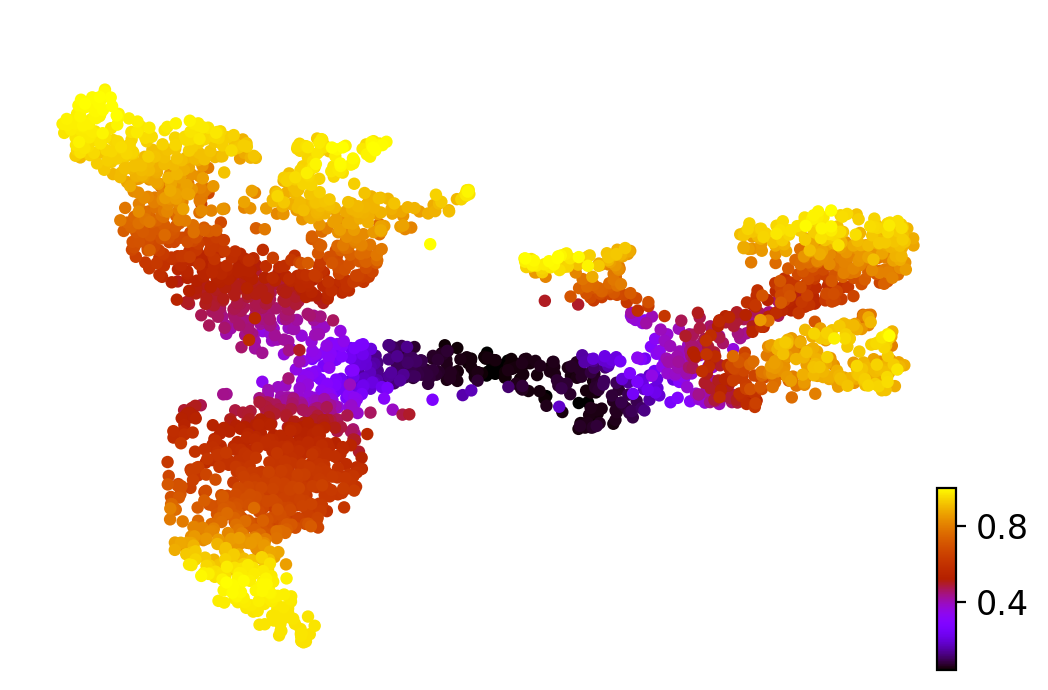

In [101]:
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad')
Answer=pd.read_csv('/data1/zzhou/pseudotime/scPN/data/Dentateanswer/time_embedding_KNN.csv').values
n=len(Answer)
adata.obs['latent_time']=Answer
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot',size=80, basis='X_umap')

Running scvelo 0.2.5 (python 3.9.12) on 2024-08-10 17:52.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/an

Filtered out 22484 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


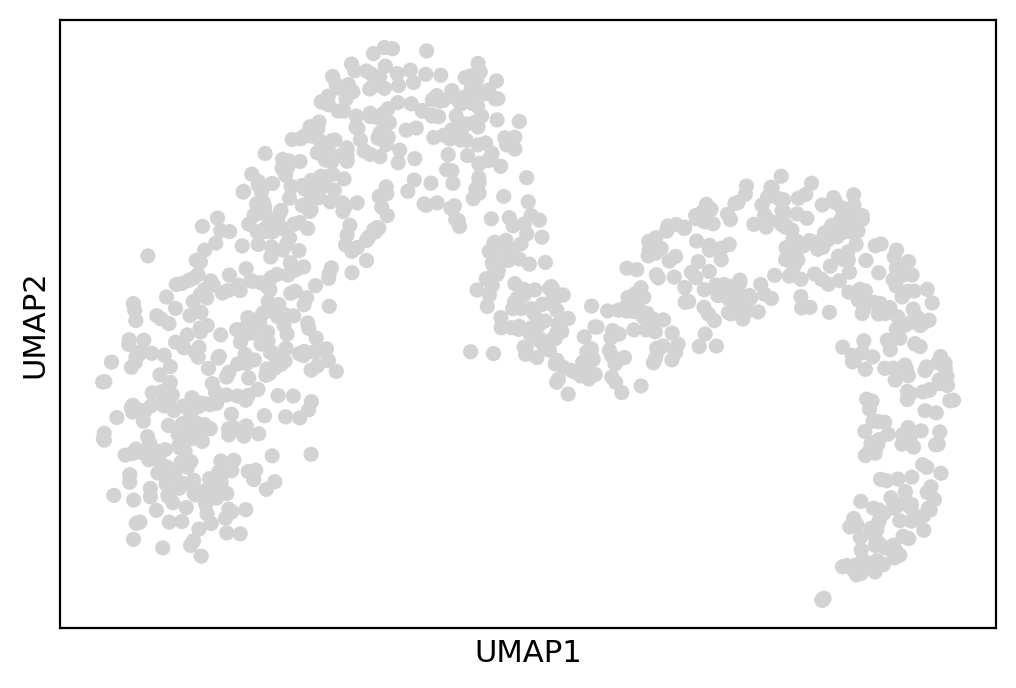

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

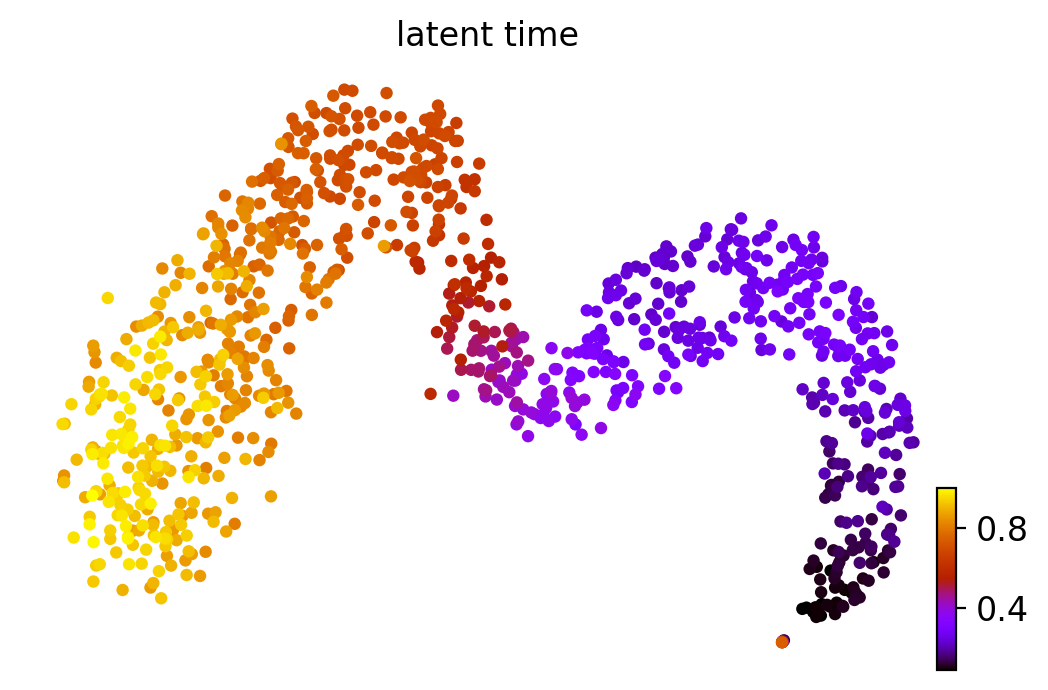

In [29]:
#preprocess
import scanpy as sc
import scvelo as scv
raw_data_path='/data1/zzhou/pseudotime/scPN/data/oligo_lite.h5ad'
adata=sc.read(raw_data_path,sparse=True)
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata_1000=sc.pp.subsample(adata, fraction=None, n_obs=1000, random_state=0, copy=True)
sc.tl.leiden(adata_1000, resolution=0.1)
sc.pl.umap(adata_1000)
adata_1000.write('/data1/zzhou/pseudotime/scPN/data/oligo_lite_1000.h5ad')
#add gene matrix
data_path='/data1/zzhou/pseudotime/scPN/data/oligo_lite_1000.h5ad'
gene_path='/data1/zzhou/pseudotime/scPN/data/ChEA_2016.txt'
adata=sc.read(data_path)
gene_names = list(adata.var_names)
target_idx=np.zeros((len(gene_names),len(gene_names)))
gene_names= [name.upper() for name in gene_names]
with open(gene_path, "r") as f:
     for line in f.readlines():
         line = line.strip('\n')
         line = line.split('\t')
         TF_info = line[0]
         TF_name = TF_info.split(' ')[0]
         if not TF_name in gene_names:
            continue
         targets= line[2:]
         for target in targets:
             if target in gene_names:
                target_idx[gene_names.index(TF_name),gene_names.index(target)]=1
                

neighbors=100
n_filename = '/data1/zzhou/pseudotime/scPN/data/oligo_answer.csv'
if not os.path.exists(n_filename):
    print(1)
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/oligo_lite_1000.h5ad')
Answer=pd.read_csv(filename).values
n=len(Answer)
q=0
U=np.zeros(n)
for i in range(n):
    
    U[Answer[-i]-1]=1/n*q
    q+=1
adata.obs['latent_time']=U
scv.pp.neighbors(adata, n_neighbors=neighbors)
neighbor_matrix=adata.uns['neighbors']['indices']
neighbor_matrix=adata.uns['neighbors']['indices']
k=neighbors
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata.obs['latent_time']=U_KNN/U_KNN.max()
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot',size=80, basis='X_umap')           

Running scvelo 0.2.5 (python 3.9.12) on 2024-08-10 18:10.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/an

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:22) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


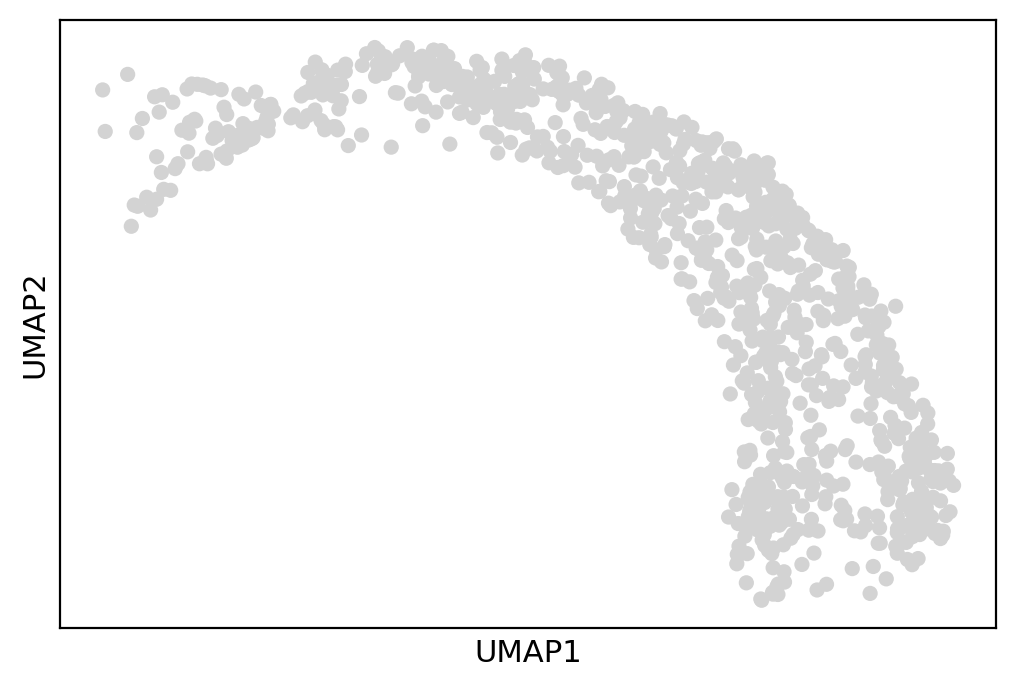

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

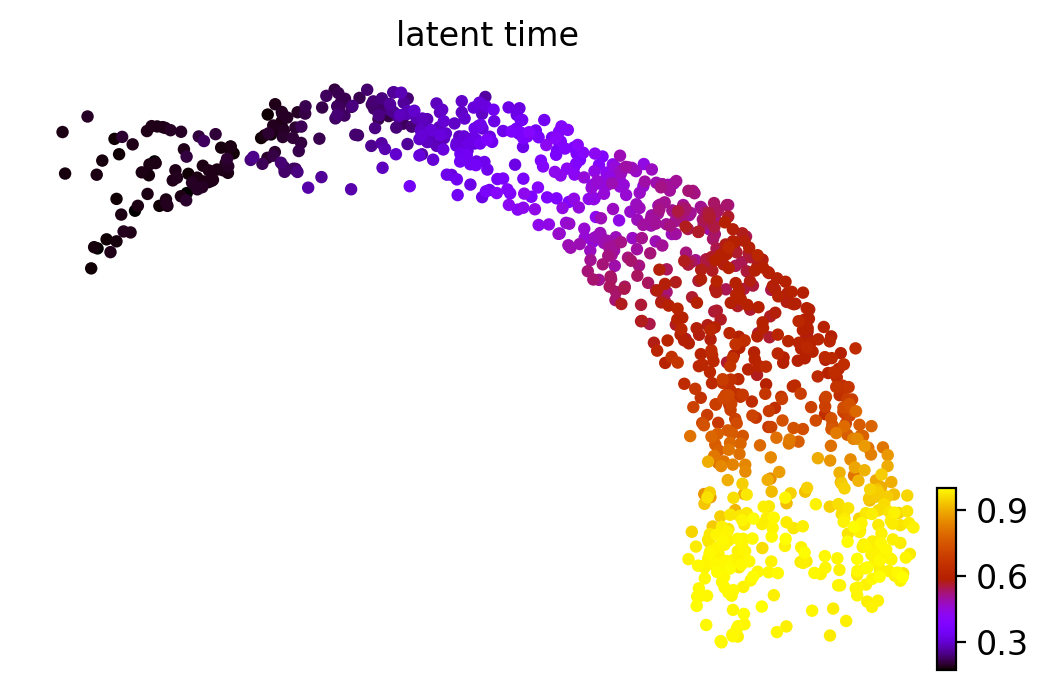

In [30]:
#preprocess
import scanpy as sc
import scvelo as scv
raw_data_path='/data1/zzhou/pseudotime/scPN/data/gastrulation.h5ad'
adata=sc.read(raw_data_path,sparse=True)
import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.set_figure_params()

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata_1000=sc.pp.subsample(adata, fraction=None, n_obs=1000, random_state=0, copy=True)
sc.tl.leiden(adata_1000, resolution=0.1)
sc.pl.umap(adata_1000)
adata_1000.write('/data1/zzhou/pseudotime/scPN/data/gastrulation_1000.h5ad')
#add gene matrix
data_path='/data1/zzhou/pseudotime/scPN/data/gastrulation_1000.h5ad'
gene_path='/data1/zzhou/pseudotime/scPN/data/ChEA_2016.txt'
adata=sc.read(data_path)
gene_names = list(adata.var_names)
target_idx=np.zeros((len(gene_names),len(gene_names)))
gene_names= [name.upper() for name in gene_names]
with open(gene_path, "r") as f:
     for line in f.readlines():
         line = line.strip('\n')
         line = line.split('\t')
         TF_info = line[0]
         TF_name = TF_info.split(' ')[0]
         if not TF_name in gene_names:
            continue
         targets= line[2:]
         for target in targets:
             if target in gene_names:
                target_idx[gene_names.index(TF_name),gene_names.index(target)]=1
                

neighbors=100
n_filename = '/data1/zzhou/pseudotime/scPN/data/gastrulation_answer.csv'
def optimize_matrix_A(route,cluster='0', adata_file='/data1/zzhou/pseudotime/scPN/data/gastrulation_1000.h5ad',epochs=50000, lr=0.001):
    adata = sc.read(adata_file)
    adata_0 = adata[adata.obs['leiden'] == cluster].X
    x = adata_0.toarray()
    n, m = x.shape
    X1=torch.tensor(x,device='cuda',dtype=torch.float32)


    # 初始化需要优化的矩阵A和矩阵W
    A = np.ones((m, m))  # 根据具体需求初始化
#     target_idx = np.random.randn(m, m)  # 这个变量需要定义或从数据中获取
    W = target_idx.cpu().detach().numpy()  # 假设W矩阵和target_idx相关

    # 根据W矩阵定义掩码矩阵
    mask = np.where(W != 0, 1, 0)
    mask_gpu = torch.tensor(mask, device='cuda', dtype=torch.float64)

    # 确保矩阵A中对应W为零的位置也为零
    A *= mask
    A_gpu = torch.tensor(A, requires_grad=True, device='cuda', dtype=torch.float64)

    # 初始化优化器
    optimizer = optim.Adam([A_gpu], lr=lr)

    # 定义目标函数
    def objective_function_A(A, route):
        scalar = torch.tensor(1, device='cuda', dtype=torch.float64)
        target_idx_gpu = torch.tensor(target_idx, device='cuda', dtype=torch.float64)
        dy_gpu = torch.tensor(dy(route, x), device='cuda', dtype=torch.float64)
        Ones = torch.ones(m, m, device='cuda', dtype=torch.float64)
        W_gpu = torch.tensor(W, device='cuda', dtype=torch.float64)
        X1=torch.tensor(x,device='cuda')

#         distance_matrix=distance_matrix2.cpu().detach().numpy()
#         total_distance = 0.0
#         for i in range(len(route) - 1):
#             total_distance += distance_matrix[route[i]-1, route[i + 1]-1]
        W_reciprocal = torch.reciprocal(100 * target_idx_gpu + scalar * Ones)

        x_t = np.zeros((n, m))
        for i in range(n):
            x_t[i] = x[route[i] - 1, :]
        x_t_gpu = torch.tensor(x_t[2:n-3, :], device='cuda', dtype=torch.float64)
#         distance_matrix2=torch.cdist(X1A,X1A,p=2)
        X1A_gpu = torch.mm(x_t_gpu, A)
        W_hadamard_A_gpu = torch.mul(W_reciprocal, A)
        matrix = dy_gpu - X1A_gpu
        matrix_norm = torch.norm(matrix, p='fro')
        W_hadamard_A_norm = torch.norm(W_hadamard_A_gpu, p='fro')
        x_t_minus=torch.diff(x_t_gpu, dim=0)
        total_distance=torch.norm(torch.mm(x_t_minus,A),p='fro')
        loss = matrix_norm+W_hadamard_A_norm
        return loss

    def dy(route, x):
        m, n = x.shape
        dy1 = np.zeros((m-5, n))
        deltat = 1 / (m-1)
        for t in range(2, m - 3):
            dy1[t - 2, :] = (8 * x[route[t + 1]-1, :] - 8 * x[route[t - 1]-1, :] + x[route[t - 2]-1, :] - x[route[t + 2]-1, :]) / (12 * deltat)
        return dy1

    # 进行优化迭代
    for i in range(epochs):
        optimizer.zero_grad()  # 每次迭代前将梯度清零
        loss = objective_function_A(A_gpu, route)
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新矩阵A的数值
        
        # 应用掩码，使非优化元素保持为零
        with torch.no_grad():
            A_gpu *= mask_gpu
        
        if i % 1000 == 0:  # 每1000次迭代打印一次损失
            print(f"Iteration {i}, loss: {loss.item()}")

#     print("Optimized matrix A:")
    return A_gpu.cpu().detach().numpy()

def getdistance(A,adata):
    u, s, v = np.linalg.svd(A)
    n,m=adata.shape
    X1=torch.tensor(adata,device='cuda',dtype=torch.float32)

    A=torch.tensor(A,device='cuda',dtype=torch.float32)
    X1A=torch.mm(X1, A)
# print(XA.shape,XB.shape,type(XA),type(XB))
    distance_matrix1=torch.cdist(X1, X1, p=2)
    distance_matrix2=torch.dist(X1A,X1A,p=2)
    distance_matrix=distance_matrix1+distance_matrix2/(s[0]+1)
    distance=np.array(distance_matrix.cpu())
    return distance
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing
from python_tsp.heuristics import solve_tsp_local_search
if not os.path.exists(n_filename):
    A = np.zeros((x.shape[1], x.shape[1]))
    best_route = None
    for iteration in range(10):
        distance_matrix = getdistance(A, x)
        route, _ = solve_tsp_simulated_annealing(distance_matrix)
        route, _ = solve_tsp_local_search(distance_matrix)
        A = optimize_matrix_A(route, cluster=cluster, adata_file=adata_file)
    
    # Save the best route for the current cluster
    route_df = pd.DataFrame(route)
    route_df.to_csv('/data1/zzhou/pseudotime/scPN/data/gastrulation_answer.csv', index=False)
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/gastrulation_1000.h5ad')
Answer=pd.read_csv(n_filename).values
n=len(Answer)
q=0
U=np.zeros(n)
for i in range(n):
    
    U[Answer[-i]-1]=1/n*q
    q+=1
adata.obs['latent_time']=U
scv.pp.neighbors(adata, n_neighbors=neighbors)
neighbor_matrix=adata.uns['neighbors']['indices']
neighbor_matrix=adata.uns['neighbors']['indices']
k=neighbors
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata.obs['latent_time']=U_KNN/U_KNN.max()
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80,basis='X_umap')               

(3001, 1)

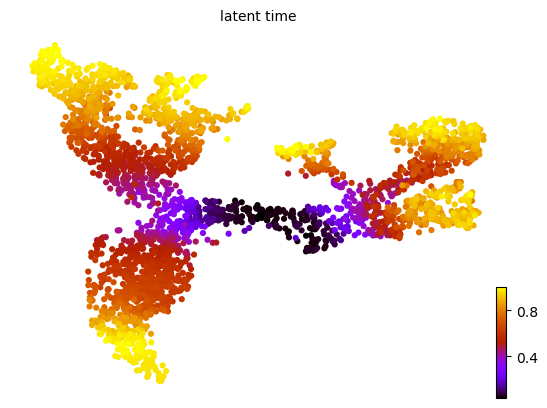

In [13]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad')
Answer=pd.read_csv('/data1/zzhou/pseudotime/scPN/data/Dentateanswer/time_embedding_KNN.csv').values
adata.obs['latent_time']=Answer
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot',size=80, basis='X_umap')

各行满足大于阈值的元素个数排序结果 (前15名):
行 Sox9: 1450.0 个
行 Olig2: 1388.0 个
行 E2f1: 1330.0 个
行 Stat3: 1310.0 个
行 Egr1: 1089.0 个
行 Rest: 1005.0 个
行 Klf4: 943.0 个
行 Foxo3: 735.0 个
行 Rbpj: 666.0 个
行 Foxp1: 640.0 个
行 Jarid2: 515.0 个
行 Meis1: 502.0 个
行 Bach1: 495.0 个
行 Cux1: 479.0 个
行 Smad1: 474.0 个
行 Nr3c1: 470.0 个
行 Tcf3: 456.0 个
行 Eomes: 446.0 个
行 Foxo1: 367.0 个
行 Myb: 356.0 个
行 Sox6: 317.0 个
行 Yap1: 310.0 个
行 Bcor: 297.0 个
行 Zfp57: 282.0 个
行 Nfe2l2: 273.0 个
行 Foxp2: 269.0 个
行 Rela: 268.0 个
行 Dach1: 253.0 个
行 Neurod2: 250.0 个
行 Tfap2c: 231.0 个
行 Atf3: 231.0 个
行 Smc4: 222.0 个
行 Prdm5: 212.0 个
行 Ezh2: 202.0 个
行 Rarb: 197.0 个
行 Ebf1: 187.0 个
行 Etv1: 187.0 个
行 Klf6: 182.0 个
行 Elk3: 182.0 个
行 Tcf7l2: 167.0 个
行 Rad21: 155.0 个
行 Pax6: 154.0 个
行 Kdm5a: 140.0 个
行 Ets1: 129.0 个
行 Tdrd3: 120.0 个
行 Auts2: 86.0 个
行 Rcor2: 70.0 个
行 Elf1: 65.0 个
行 Rac3: 62.0 个
行 Nr4a2: 62.0 个
行 Notch1: 41.0 个
行 Sall1: 22.0 个
行 Chd7: 12.0 个
行 Prdm16: 9.0 个
行 Bcl11b: 7.0 个
行 Nfib: 4.0 个
行 Dhcr24: 0.0 个
行 Smc2: 0.0 个
行 Grik3: 0.0 个
行 Tg

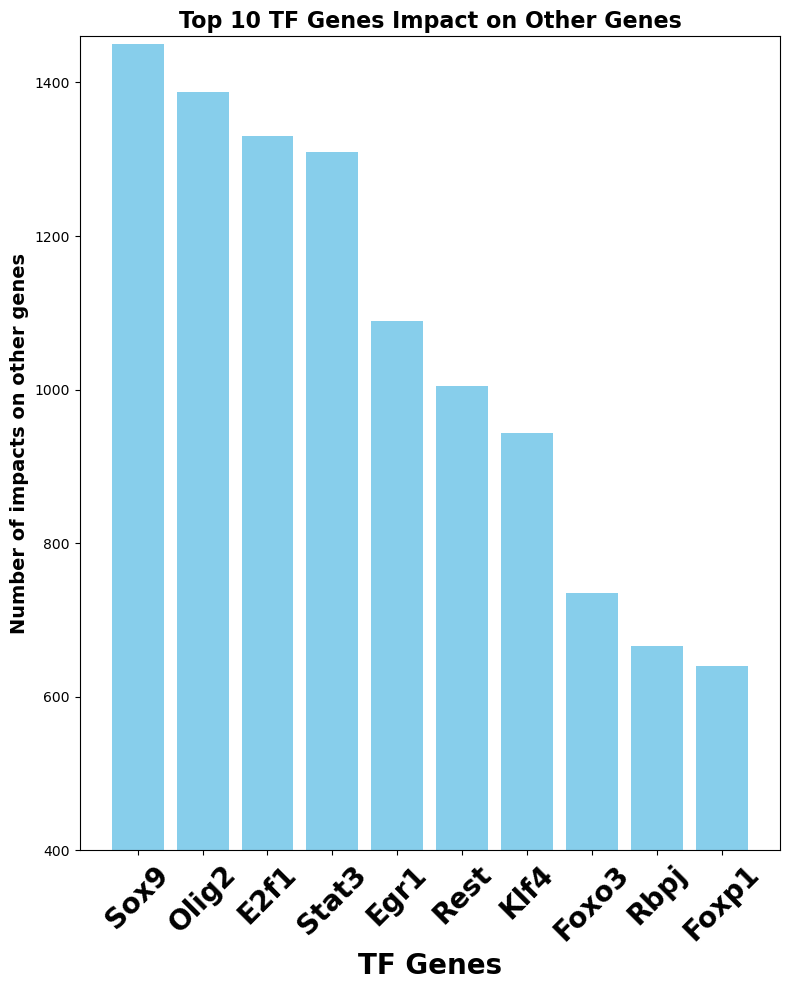

In [18]:
import numpy as np
from scipy.sparse import csr_matrix
import numpy as np
A_0=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_0_connection.csv",delimiter=",")
A_1=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_1_connection.csv",delimiter=",")
A_2=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_2_connection.csv",delimiter=",")
A_3=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_3_connection.csv",delimiter=",")
A_4=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_4_connection.csv",delimiter=",")
A_5=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_5_connection.csv",delimiter=",")
A_6=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_6_connection.csv",delimiter=",")
A_7=np.loadtxt("/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_7_connection.csv",delimiter=",")

# 定义更多的矩阵 A2, A3, ... A6
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad')
# 列出所有矩阵
matrices = [A_0, A_1, A_2, A_3, A_4, A_5, A_6, A_7]  # 你可以添加更多的矩阵 A2, A3, ... A6

# 假设 adata.var_names 是一个包含列名称的列表
# 设置阈值
threshold = 0.85

def normalize_matrix(matrix):
    """对矩阵的每一列进行归一化，使得每一列的绝对值最大的元素变为1"""
    abs_matrix = np.abs(matrix)
    max_elements = abs_matrix.max(axis=0)
    max_elements[max_elements == 0] = 1  # 防止除以0的情况
    normalized_matrix = matrix / max_elements[None, :]
    return normalized_matrix

def count_large_elements(matrix, threshold):
    """计算每行中满足大于阈值的元素个数"""
    sparse_matrix = csr_matrix(matrix)
    rows, cols = sparse_matrix.nonzero()
    data = sparse_matrix.data
    
    large_elements_count = np.zeros(sparse_matrix.shape[0])  # 计算行的元素个数
    
    for i, val in enumerate(data):
        if abs(val) > threshold:
            large_elements_count[rows[i]] += 1  # 对行的元素进行计数
    
    return large_elements_count

# 归一化矩阵并计算每行中满足大于阈值的元素个数
total_large_elements_count = np.zeros(matrices[0].shape[0])

for matrix in matrices:
    normalized_matrix = normalize_matrix(matrix)
    large_elements_count = count_large_elements(normalized_matrix, threshold)
    total_large_elements_count += large_elements_count

# 对总的计数结果进行排序
sorted_indices = np.argsort(-total_large_elements_count)[:100]
sorted_counts = total_large_elements_count[sorted_indices]
sorted_var_names = [adata.var_names[i] for i in sorted_indices]

# 打印结果
print("各行满足大于阈值的元素个数排序结果 (前15名):")
for i, count in enumerate(sorted_counts):
    print(f"行 {sorted_var_names[i]}: {count} 个")
import matplotlib.pyplot as plt

# 假设 sorted_var_names 和 sorted_counts 是已经排好序的变量名和对应的影响个数
top_genes = sorted_var_names[:10]
impact_counts = sorted_counts[:10]

plt.figure(figsize=(8, 10))  # 调整图的大小
plt.bar(top_genes, impact_counts, color='skyblue')

# 设置x轴标签为黑体并加大字体
plt.xlabel('TF Genes', fontsize=20, fontweight='bold')  # x轴标签改为英文
# 设置y轴标签并加大字体
plt.ylabel('Number of impacts on other genes', fontsize=14, fontweight='bold')  # y轴标签改为英文
# 设置标题并加大字体
plt.title('Top 10 TF Genes Impact on Other Genes', fontsize=16, fontweight='bold')  # 标题改为英文

# 旋转x轴标签，使其更易读
plt.xticks(rotation=45, fontsize=20, fontweight='bold')

# 调整y轴范围，使其从400开始
plt.ylim(400, max(impact_counts) + 10)

plt.tight_layout()  # 调整布局，避免标签被截断
plt.show()


In [ ]:
#contrast
# import velovi as vv
import scanpy as sc
import scvelo as scv

adata=sc.read('adata3000_imputed_leiden11_ID.h5ad')

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)
scv.pl.velocity_embedding_stream(adata, basis='umap')
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [ ]:
#preprocess
import scanpy as sc
import scvelo as scv

import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
import pandas as pd
neighbors=30
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/gastrulation_1000.h5ad')
n_filename = '/data1/zzhou/pseudotime/scPN/data/gastrulation_answer.csv'
Answer=pd.read_csv(n_filename).values
n=len(Answer)
q=0
U=np.zeros(n)
for i in range(n):
    
    U[Answer[-i]-1]=1/n*q
    q+=1
adata.obs['latent_time']=U
scv.pp.neighbors(adata, n_neighbors=neighbors)
neighbor_matrix=adata.uns['neighbors']['indices']
neighbor_matrix=adata.uns['neighbors']['indices']
k=neighbors
U_KNN=np.zeros(n)
for i in range(n):
    for j in range(k):
        U_KNN[i]+=U[neighbor_matrix[i,j]]
    U_KNN[i]=U_KNN[i]/k
adata.obs['latent_time']=U_KNN/U_KNN.max()
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80,basis='X_umap')
final_time=list(adata.obs['latent_time'])
sorted_indices = np.argsort(final_time)

In [ ]:
adata_X=adata.X.toarray()
# adata_X=adata_X[:,k_smallest_indices]
n,m=adata_X.shape
velocity=np.zeros((n,m))
for i in range(n-100):
    velocity[sorted_indices[i],:]=(adata_X[sorted_indices[i+100],:]-adata_X[sorted_indices[i],:])

adata.layers['velocity']=velocity
gene_total_loss=np.zeros(m)
k=500
for i in range(n-1):
    for j in range(m):
        gene_total_loss[j]+=np.linalg.norm(adata_X[i+1,j]-adata_X[i,j])
sorted_indices_genes = np.argsort(gene_total_loss)
k_smallest_indices = sorted_indices_genes[:k]
from anndata import AnnData
adata_X=adata.X.toarray()
adata_X_sub=adata_X[:,k_smallest_indices]
adata_sub= AnnData(adata_X_sub)
adata_sub.var_names=adata.var_names[k_smallest_indices]
adata_sub.layers['velocity']=adata.layers['velocity'][:,k_smallest_indices]
adata_sub.obs=adata.obs
adata_sub.obs['sample']=adata.obs['sample']
adata_sub.obs['latent_time']=adata.obs['latent_time']
adata_sub.layers['Ms']=adata.layers['Ms'][:,k_smallest_indices]
adata_sub.layers['Mu']=adata.layers['Mu'][:,k_smallest_indices]
adata_sub.layers['spliced']=adata.layers['spliced'][:,k_smallest_indices]
adata_sub.layers['unspliced']=adata.layers['unspliced'][:,k_smallest_indices]
adata_sub.obsm['X_umap']=adata.obsm['X_umap']
adata_sub.uns['neighbors']=adata.uns['neighbors']
adata_sub.obsp['distances']=adata.obsp['distances']
adata_sub.obsp['connectivities']=adata.obsp['connectivities']
scv.tl.velocity_graph(adata_sub)

scv.pl.velocity_embedding_grid(
    adata_sub,


    color='latent_time',
    basis='umap',
    density=0.8,
    min_mass=0.5,
    smooth=1.2,
    title='Velocity Field on UMAP',

    show=True
)
scv.pl.velocity_embedding_stream(
    adata_sub,


    color='latent_time',
    basis='umap',
    density=1.0,
    min_mass=1.2,
    smooth=1.2,
    title='Velocity Field on UMAP',

    show=True
)


In [1]:
#preprocess
import scanpy as sc
import scvelo as scv

import numpy as np
np.bool=np.bool_
np.int=np.int_
np.object = object
import scvelo as scv
import scanpy as sc
import pandas as pd

/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
data_path='/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad'
adata=sc.read(data_path)

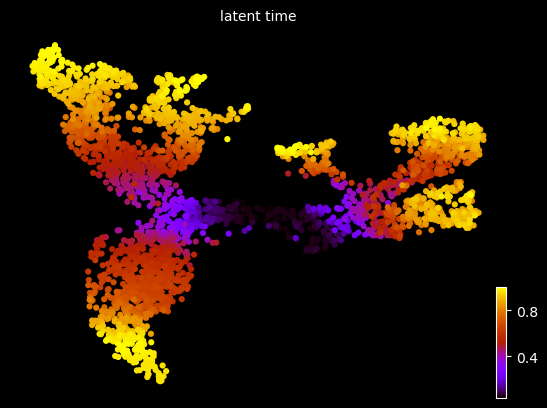

In [3]:
adata=sc.read('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad')
Answer=pd.read_csv('/data1/zzhou/pseudotime/scPN/data/Dentateanswer/time_embedding_KNN.csv').values
n=len(Answer)
adata.obs['latent_time']=Answer
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot',size=80, basis='X_umap')

In [4]:
def find_closest_larger_index(my_list, value):

    larger_elements = [(i, num) for i, num in enumerate(my_list) if num > value]
    
    if not larger_elements:
        return None 

    closest_index, closest_value = min(larger_elements, key=lambda x: x[1] - value)
    return closest_index
def find_kth_larger_index(my_list, x, k):

    larger_elements_with_index = [(num, idx) for idx, num in enumerate(my_list) if num > x]
    

    if len(larger_elements_with_index) < k:
        return None  
    

    larger_elements_with_index.sort(key=lambda pair: pair[0])
    

    return larger_elements_with_index[k - 1][1]


n,m=adata.X.shape
velocity=np.zeros((n,m))
for i in range(3000):
    leiden_mask=int(adata[i].obs['leiden'].to_numpy())
    if leiden_mask in [0,1,2,3,4,5,6,7]:
        # sum+=1
        if leiden_mask==0:
            k=150
        else:
            k=30
        adata_tmp=adata[adata.obs['leiden']==str(leiden_mask)]
        final_time_tmp=list(adata_tmp.obs['latent_time'])
        # sorted_indices_tmp = np.argsort(final_time_tmp)
        index_tmp=find_kth_larger_index(final_time_tmp, adata[i].obs['latent_time'].values,k)
        # connection_tmp=pd.read_csv(f'/data1/zzhou/pseudotime/scPN/data/Dentateanswer/adata_{leiden_mask}_connection.csv',header=None)
        if index_tmp!=None:
            velocity[i,:]=adata_tmp.X.toarray()[index_tmp,:]-adata.X.toarray()[i,:]

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/40 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


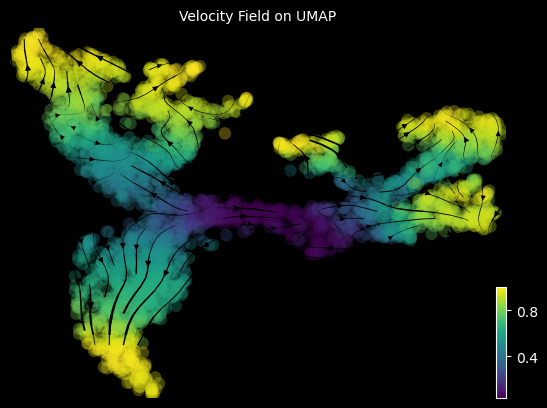

In [6]:
neighbors=50
adata.layers['velocity']=velocity
scv.pp.neighbors(adata, n_neighbors=neighbors)
scv.tl.velocity_graph(adata)

scv.pl.velocity_embedding_stream(
    adata,


    color='latent_time',
    basis='umap',
    density=1.2,
    min_mass=2.0,
    cutoff_perc=0.95,
    smooth=0.8,
    # adjust_for_stream=False,
    arrow_size=0.8,
    title='Velocity Field on UMAP',

    show=True
)

/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Filtered out 22484 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/tools/optimization.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/6253 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

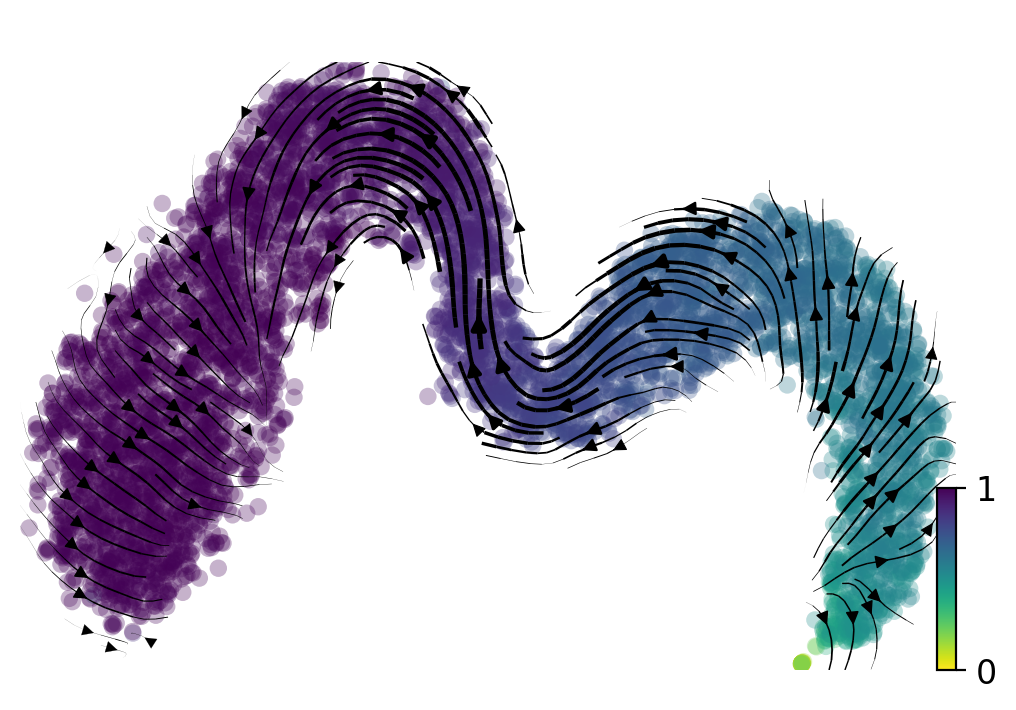

In [102]:
##Contrst Scvelo
#30s 500M
import scvelo as scv
import scanpy as sc

# 1. 读取数据并预处理
adata = sc.read('/data1/zzhou/pseudotime/scPN/data/oligo_lite.h5ad') # 示例数据集，也可以是你自己的 AnnData 对象
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# 2. 计算 RNA velocity
scv.tl.velocity(adata, mode='stochastic')  # 也可以尝试 'dynamical' 或 'deterministic'
scv.tl.velocity_graph(adata)

# 3. 计算 pseudotime
scv.tl.velocity_pseudotime(adata)

# 4. 可视化
scv.pl.velocity_embedding_stream(adata, color='velocity_pseudotime')


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/tools/optimization.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

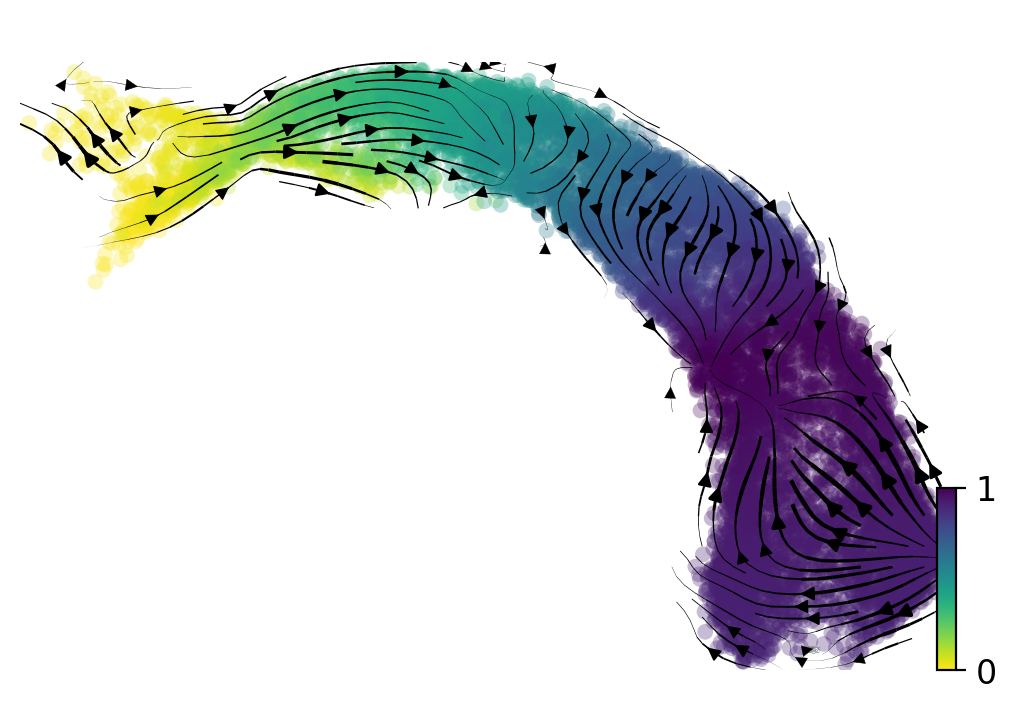

In [103]:
##Contrst Scvelo
#30s 600M
import scvelo as scv
import scanpy as sc

# 1. 读取数据并预处理
adata = sc.read('/data1/zzhou/pseudotime/scPN/data/erythroid_lineage.h5ad') # 示例数据集，也可以是你自己的 AnnData 对象
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# 2. 计算 RNA velocity
scv.tl.velocity(adata, mode='stochastic')  # 也可以尝试 'dynamical' 或 'deterministic'
scv.tl.velocity_graph(adata)

# 3. 计算 pseudotime
scv.tl.velocity_pseudotime(adata)

# 4. 可视化
scv.pl.velocity_embedding_stream(adata, color='velocity_pseudotime')


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Filtered out 727 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/tools/optimization.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

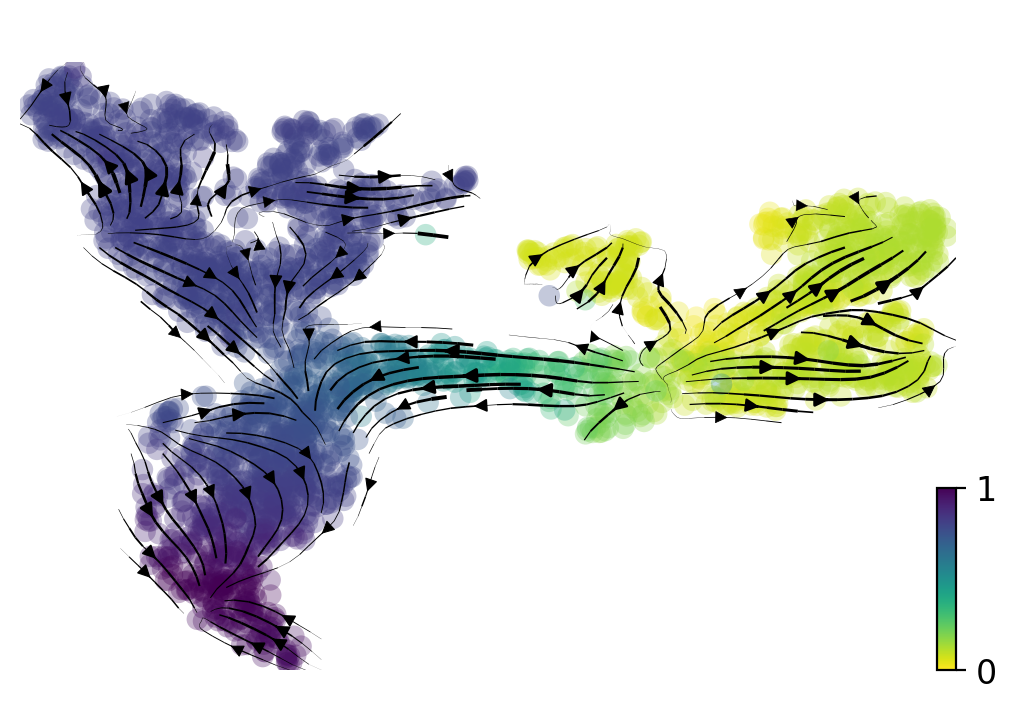

In [105]:
##Contrst Scvelo
#30s 600M
import scvelo as scv
import scanpy as sc

# 1. 读取数据并预处理
adata = sc.read('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad') # 示例数据集，也可以是你自己的 AnnData 对象
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.pp.neighbors(adata)
# 2. 计算 RNA velocity
scv.tl.velocity(adata, mode='stochastic')  # 也可以尝试 'dynamical' 或 'deterministic'
scv.tl.velocity_graph(adata)

# 3. 计算 pseudotime
scv.tl.velocity_pseudotime(adata)

# 4. 可视化
scv.pl.velocity_embedding_stream(adata, color='velocity_pseudotime')


In [121]:
#Plantir
import scanpy as sc
import palantir
import pandas as pd

# 1. 读取数据
adata = sc.read_h5ad('/data1/zzhou/pseudotime/scPN/data/oligo_lite.h5ad')

# 2. 正规化 & PCA
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# 3. 计算距离图
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

# 4. Diffusion map（Palantir 使用）
from palantir import utils, core

dm_res = palantir.utils.run_diffusion_maps(adata, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(adata)

# 5. 指定起始细胞（例：某个干细胞或你认为最早的细胞）
# 可以用你已有的注释或选择UMAP最左边的细胞
start_cell = adata.obs_names[adata.obsm['X_umap'][:, 0].argmin()]
start_cell='10X55_5:GCATACAGTGTGAATAx'
# 6. 运行 Palantir
pr_res = core.run_palantir(adata,early_cell=start_cell,num_waypoints=500)

# 7. 存储结果
adata.obs['palantir_pseudotime'] = pr_res.pseudotime.values


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Sampling and flocking waypoints...
Time for determining waypoints: 0.005602641900380453 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: U

Time for shortest paths: 0.27152800957361856 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9996
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

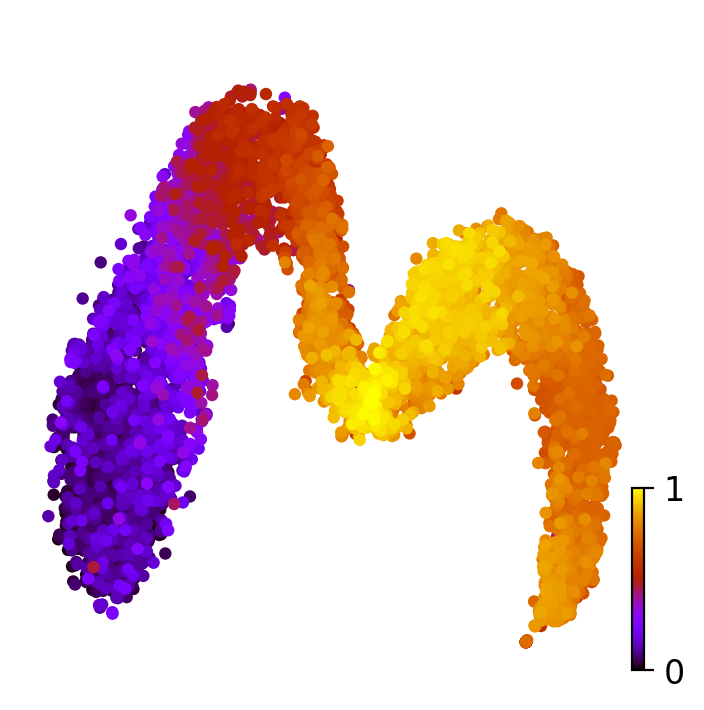

In [124]:
scv.pl.scatter(adata, color='palantir_pseudotime', color_map='gnuplot', size=80,basis='X_umap')

/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Sampling and flocking waypoints...
Time for determining waypoints: 0.005846273899078369 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: U

Time for shortest paths: 0.26867067416508994 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

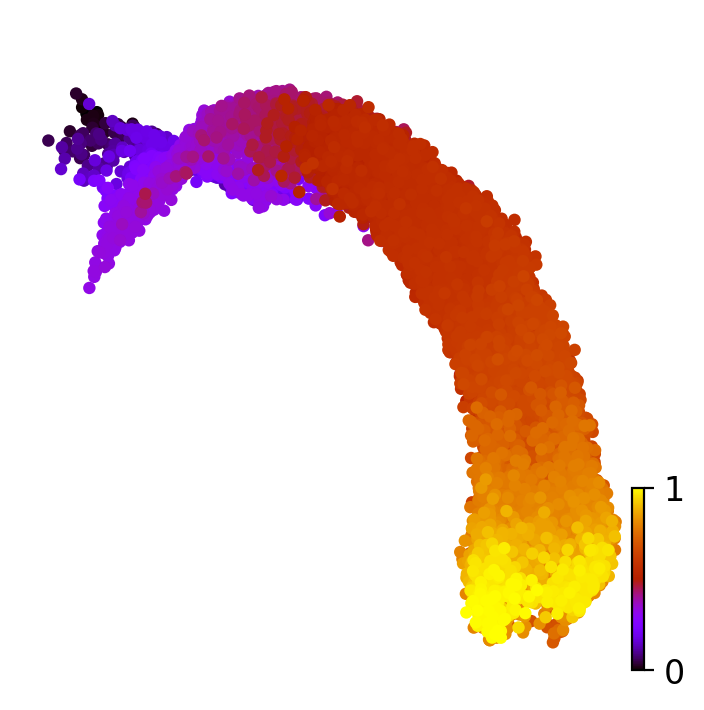

In [127]:
#Plantir
import scanpy as sc
import palantir
import pandas as pd

# 1. 读取数据
adata = sc.read_h5ad('/data1/zzhou/pseudotime/scPN/data/erythroid_lineage.h5ad')

# 2. 正规化 & PCA
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# 3. 计算距离图
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

# 4. Diffusion map（Palantir 使用）
from palantir import utils, core

dm_res = palantir.utils.run_diffusion_maps(adata, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(adata)

# 5. 指定起始细胞（例：某个干细胞或你认为最早的细胞）
# 可以用你已有的注释或选择UMAP最左边的细胞
start_cell = adata.obs_names[adata.obsm['X_umap'][:, 0].argmin()]

# 6. 运行 Palantir
pr_res = core.run_palantir(adata,early_cell=start_cell,num_waypoints=500)

# 7. 存储结果
adata.obs['palantir_pseudotime'] = pr_res.pseudotime.values
scv.pl.scatter(adata, color='palantir_pseudotime', color_map='gnuplot', size=80,basis='X_umap')

/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is d

Sampling and flocking waypoints...
Time for determining waypoints: 0.002694515387217204 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


Time for shortest paths: 0.037525888284047446 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Project results to all cells...


/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python3.9/site-packages/scvelo/plotting/utils.py:56: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data1/zzhou/anaconda3/envs/tensorflow/lib/python

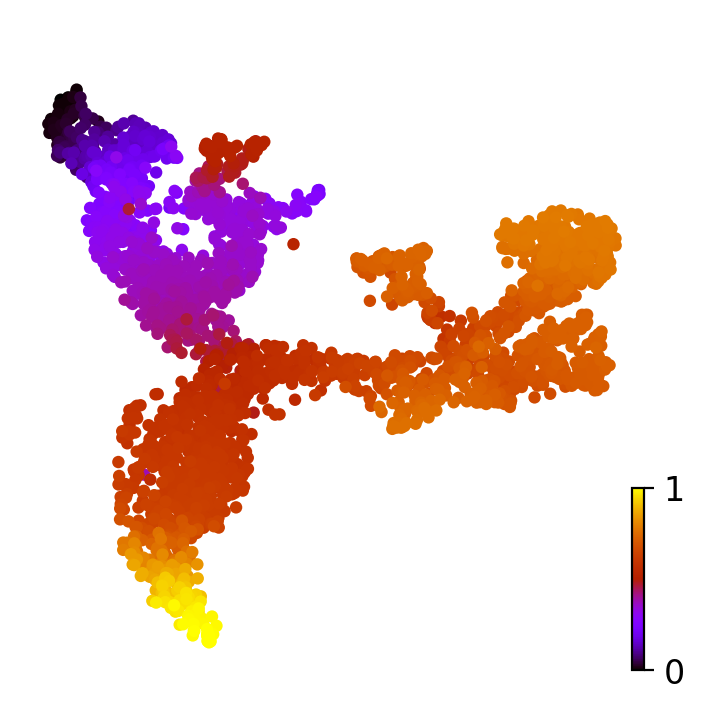

In [129]:
#Plantir
import scanpy as sc
import palantir
import pandas as pd

# 1. 读取数据
adata = sc.read_h5ad('/data1/zzhou/pseudotime/scPN/data/adata3000_imputed_leiden11_ID.h5ad')

# 2. 正规化 & PCA
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# 3. 计算距离图
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

# 4. Diffusion map（Palantir 使用）
from palantir import utils, core

dm_res = palantir.utils.run_diffusion_maps(adata, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(adata)

# 5. 指定起始细胞（例：某个干细胞或你认为最早的细胞）
# 可以用你已有的注释或选择UMAP最左边的细胞
start_cell = adata.obs_names[adata.obsm['X_umap'][:, 0].argmin()]

# 6. 运行 Palantir
pr_res = core.run_palantir(adata,early_cell=start_cell,num_waypoints=500)

# 7. 存储结果
adata.obs['palantir_pseudotime'] = pr_res.pseudotime.values
scv.pl.scatter(adata, color='palantir_pseudotime', color_map='gnuplot', size=80,basis='X_umap')

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/data1/zzhou/anaconda3/envs/velovi-env/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#veloVI
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载数据
adata =sc.read('/data/zhenz/oligo_lite.h5ad')

# 2. 预处理（确保包含 spliced / unspliced）
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# 3. 设置 Velovi 的模型参数
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)


Filtered out 23116 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_2024467/2418712531.py:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 500/500: 100%|██████████| 500/500 [06:20<00:00,  1.28it/s, v_num=1, train_loss_step=-3.37e+3, train_loss_epoch=-3.46e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [06:20<00:00,  1.32it/s, v_num=1, train_loss_step=-3.37e+3, train_loss_epoch=-3.46e+3]


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

computing velocity graph (using 1/56 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:43) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


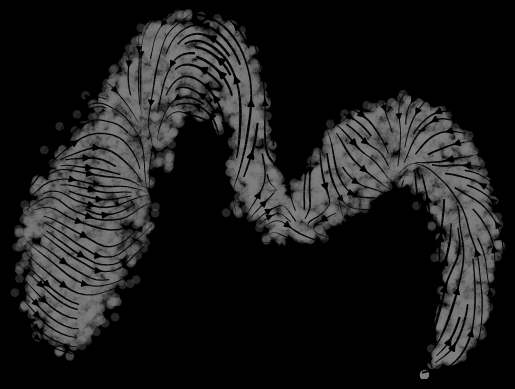

In [9]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [10]:
#veloVI
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载数据
adata =sc.read('/data/zhenz/erythroid_lineage.h5ad')

# 2. 预处理（确保包含 spliced / unspliced）
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# 3. 设置 Velovi 的模型参数
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)


Filtered out 47973 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_2024467/3796317672.py:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:29) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 36/500:   7%|▋         | 35/500 [00:42<09:23,  1.21s/it, v_num=1, train_loss_step=4.16e+5, train_loss_epoch=4.2e+5] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [11]:
#veloVI
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载数据
adata =sc.read('/data/zhenz/adata3000_imputed_leiden11_ID.h5ad')

# 2. 预处理（确保包含 spliced / unspliced）
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# 3. 设置 Velovi 的模型参数
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)


Filtered out 899 genes that are detected 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/data/zhenz/anaconda3/envs/myenv/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 283/500:  57%|█████▋    | 283/500 [01:50<01:24,  2.55it/s, v_num=1, train_loss_step=-2.18e+3, train_loss_epoch=-2.22e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1853.200. Signaling Trainer to stop.


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [10]:
adata.obs['ClusterName']

CellID
10X83_2:TCATTTGTCCCAGGTGx             CA
10X83_3:TCAGATGGTGGTCTCGx        CA2-3-4
10X84_3:AAGCCGCAGGCTATCTx     RadialGlia
10X84_3:CAAGATCGTAGGGTACx           Nbl2
10X84_2:ATAACGCTCCGGGTGTx        CA1-Sub
                                ...     
10X84_2:AGCTCCTTCCGCATCTx       ImmAstro
10X84_2:TCAGATGGTTACGTCAx    ImmGranule1
10X84_3:GAAGCAGGTCCAAGTTx       ImmAstro
10X84_3:CGTAGGCCAACTGGCCx        Granule
10X84_2:GACAGAGCAGAGTGTGx           Nbl2
Name: ClusterName, Length: 3000, dtype: category
Categories (14, object): ['CA', 'CA1-Sub', 'CA2-3-4', 'GlialProg', ..., 'OPC', 'RadialGlia', 'RadialGlia2', 'nIPC']

In [12]:
#cellDancer
import scvelo as scv
import scanpy as sc
adata =sc.read('/data/zhenz/adata3000_imputed_leiden11_ID.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors
import pandas as pd
import celldancer.utilities as cdutil
cdutil.adata_to_df_with_embed(adata,
                              us_para=['Mu','Ms'],
                              cell_type_para='ClusterName',
                              embed_para='X_umap',
                              save_path='oligocell_type_u_s.csv',
                              gene_list=adata.var_names)
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
cell_type_u_s_path='/data/zhenz/oligocell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
gene_list=adata.var_names
loss_df, cellDancer_df=cd.velocity(cell_type_u_s,\
                                   gene_list=gene_list,\
                                   permutation_ratio=0.125,\
                                   n_jobs=8)

Filtered out 727 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


100%|██████████| 1273/1273 [00:37<00:00, 34.13it/s]


Using /data/zhenz/cellDancer_velocity_2025-05-01 03-03-10 as the output path.
Arranging genes for parallel job.
1273  genes were arranged to  160  portions.


In [14]:
adata

AnnData object with n_obs × n_vars = 6253 × 2000
    obs: 'Age', 'Cell_Conc', 'ChipID', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'Target_Num_Cells', 'Tissue', 'Transcriptome', '_X', '_Y', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'V1', 'V2', 'label', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_coor', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [15]:
#cellDancer
import scvelo as scv
import scanpy as sc
adata =sc.read('/data/zhenz/oligo_lite.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors
import pandas as pd
import celldancer.utilities as cdutil
cdutil.adata_to_df_with_embed(adata,
                              us_para=['Mu','Ms'],
                              cell_type_para='celltype',
                              embed_para='X_umap',
                              save_path='oligocell_type_u_s.csv',
                              gene_list=adata.var_names)
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
cell_type_u_s_path='/data/zhenz/oligocell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
gene_list=adata.var_names
loss_df, cellDancer_df=cd.velocity(cell_type_u_s,\
                                   gene_list=gene_list,\
                                   permutation_ratio=0.125,\
                                   n_jobs=8)

Filtered out 22484 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


100%|██████████| 2000/2000 [01:44<00:00, 19.12it/s]


Using /data/zhenz/cellDancer_velocity_2025-05-01 03-33-42 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  250  portions.


Not predicted gene list:['Cenpf']. Try visualizing the unspliced and spliced columns of the gene(s) to check the quality.


In [2]:
#cellDancer
import scvelo as scv
import scanpy as sc
adata =sc.read('/data/zhenz/erythroid_lineage.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors
import pandas as pd
import celldancer.utilities as cdutil
cdutil.adata_to_df_with_embed(adata,
                              us_para=['Mu','Ms'],
                              cell_type_para='celltype',
                              embed_para='X_umap',
                              save_path='gastru_cell_type_u_s.csv',
                              gene_list=adata.var_names)
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
cell_type_u_s_path='/data/zhenz/gastru_cell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
gene_list=adata.var_names
loss_df, cellDancer_df=cd.velocity(cell_type_u_s,\
                                   gene_list=gene_list,\
                                   permutation_ratio=0.125,\
                                   n_jobs=8)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


100%|██████████| 2000/2000 [02:00<00:00, 16.62it/s]


Using /data/zhenz/cellDancer_velocity_2025-05-01 06-35-52 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  250  portions.


Not predicted gene list:['Nkg7', 'Gzmg', 'Gzmf', 'Spp1']. Try visualizing the unspliced and spliced columns of the gene(s) to check the quality.
